In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('..')

from algorithms.random_policy import RandomPolicy
from algorithms.sequence_models.decision_sequence_policy import DTPolicy
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from data.random_walk_dataset import RandomWalkDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT
from envs.random_walk import RandomWalkEnv
from experiment import Experiment
import gymnasium as gym
from functools import partial

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

device is  cuda


In [2]:
from envs.carnival import get_carnival_env

2024-05-12 01:01:43.019109: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 01:01:43.364279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 01:01:44.184449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
env = get_carnival_env()
obs, _ = env.reset()
obs.shape

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


(214, 160, 3)

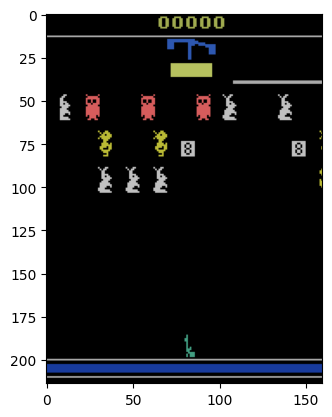

In [4]:
plt.imshow(obs)

In [5]:
import torch
import torch.nn as nn

class CNNFeatureExtractor(nn.Module):
    FEATURE_DIM = 64
    
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 3 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
    
    def forward(self, x):
        # Apply convolutional and pooling layers
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.pool(torch.relu(self.conv5(x)))
        x = self.pool(torch.relu(self.conv6(x)))
        x = x.view(-1, 128 * 3 * 2) 
        return x

# wrapper over DT. passes the features of the input through
class CarnivalDTWrapper(nn.Module):
    def __init__(self, state_dim, **kwargs):
        super(CarnivalDTWrapper, self).__init__()
        self.feature_extractor = CNNFeatureExtractor()
        self.sequence_model = DecisionTransformer(**kwargs, state_dim=self.feature_extractor.FEATURE_DIM) # change the feature size midways
        
    def forward(self, timesteps, states, actions, returns_to_go):
        states = self.feature_extractor(states)
        return self.sequence_model(timesteps, states, actions, returns_to_go)


/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/extensions/__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins.extensions')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
/snap/pycharm-professional/387/plugins/python/helpers/pydev/pydevd_plugins/e

In [ ]:
from data.carnival_dataset import CarnivalDataset

env = get_carnival_env()
env_human = get_carnival_env(render_mode='human')

episode_length = 500
config = TrainConfig(max_eval_ep_len=episode_length, context_len=128,
                     eval_model_interval=50)

#################### todo
# n_trajectories should be at least 10000 for the agent to learn I think 
####################
n_trajectories = 2000
experiment_name = f"experiment_carnival_dataset_size={n_trajectories}"
if DoorKeyDataset.exists(experiment_name):
    traj_dataset = CarnivalDataset.load(experiment_name)
else:
    traj_dataset = CarnivalDataset(env, n_trajectories=n_trajectories, reward_scale=1000)
    traj_dataset.save(experiment_name)

dt_model = CarnivalDTWrapper(
    state_dim=traj_dataset.state_dim(),
    act_dim=traj_dataset.action_dim(),
    n_blocks=config.n_blocks,
    h_dim=config.embed_dim,
    context_len=config.context_len,
    n_heads=config.n_heads,
    drop_p=config.dropout_p,
).to(device)

make_dt_policy = partial(DTPolicy, model=dt_model, traj_dataset=traj_dataset, device=device, max_test_ep_len=config.max_eval_ep_len, context_length=config.context_len)

policies_and_names = []
for rtg in [1000, 2000, 3000, 4000]:
    policies_and_names.append((make_dt_policy(rtg=rtg), f'dt,rtg={rtg}'))
policies_and_names.append((RandomPolicy(env), "random_policy"))

experiment = Experiment(
    model_name='dt',
    model=dt_model,
    env_name='Carnival-V4',
    env=env,
    experiment_name='first-try',
    traj_dataset=traj_dataset,
    dataset_name=f'size={len(traj_dataset)}',
    config=config,
    device=device,
    eval_policies_and_names=policies_and_names
)

In [9]:
env.observation_space.shape

(214, 160, 3)

In [43]:
obs, _ = env.reset()
counter = 0
done = False
counter = 0
ret = 0
while not done:
    action = env.action_space.sample()
    obs, reward, truncated, terminated, _ = env.step(action)
    done = truncated or terminated
    ret += reward
    counter += 1
    
counter, ret

(455, 1540.0)